In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random


Warning: this doesn't work. This was from Donald's code that I just changed a few things

In [2]:
def generate(string): 
    a = np.array([[1, 1, 2],[0, 1, 1],[0,-3,-2]])
    b = np.array([[-2, 0, -1],[-5, 1, -1],[3,0,1]])

    maxMats = 50
    dataPoints = 10000
    prevMat = -1


    for j in range(dataPoints):
        nextMat = random.randint(0,1)
        if nextMat == 0: 
            mat = a
            prevMat = 0
        elif nextMat == 1:
            mat = b
            prevMat = 1
        numOfMatrices = random.randint(1, maxMats)
        for i in range(numOfMatrices): 
            nextMat = random.randint(0,1)
            if (nextMat == 0):
                mat = np.matmul(a, mat)
                prevMat = nextMat
            elif (nextMat == 1):
                mat = np.matmul(b, mat)
                prevMat = nextMat
        if j == 0: 
            df = pd.DataFrame([[mat[0][0],mat[0][1],mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1],mat[2][2], prevMat]], columns = ['00', '01', '02','10','11','12', '20', '21','22',"last"])
        else: 
            df = pd.concat([df, pd.DataFrame([[mat[0][0],mat[0][1],mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1],mat[2][2], prevMat]],columns = ['00', '01', '02','10','11','12', '20', '21','22',"last"])])
# mat[0][0] = mat[0][0]  % 7
# mat [0][1] = mat[0][1]  % 7
# mat[0][2] = mat[0][2]  % 7
# mat [1][0] = mat[1][0]  % 7
# mat [1][1] = mat[1][1]  % 7
# mat [1][1] = mat[1][1]  % 7
    df.to_csv(string, index = False)

In [3]:
# code adapted from ChatGPT

# Define your neural network model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        self.step1 = nn.Linear(9, 128, bias=True)
        self.step2 = nn.ReLU()
        self.step3 = nn.Linear(128, 64, bias=True)
        self.step4 = nn.ReLU()
        self.step5 = nn.Linear(64, 16, bias=True)
        self.step6 = nn.ReLU()
        self.step7 = nn.Linear(16, 2, bias=True)

        # multi-class classification adapted from ChatGPT
        self.step8 = nn.Softmax(dim=1)

    def forward(self, x):

        # RUN IT ON A GPU if it exists
        if torch.cuda.is_available():
            x = x.to("cuda")

        x = self.step1(x)
        x = self.step2(x)
        x = self.step3(x)
        x = self.step4(x)
        x = self.step5(x)
        x = self.step6(x)
        x = self.step7(x)
        x = self.step8(x)
        
        return x

def train_model(inputs, desired_outputs, num_epochs=1000, learning_rate=0.01, viz_accuracy=False):
    # Convert inputs and desired_outputs to PyTorch tensors
    inputs = torch.tensor(inputs, dtype=torch.float32)
    desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)
    
    # Create a DataLoader to handle batching (if needed)
    dataset = TensorDataset(inputs, desired_outputs)
    dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)  # Adjust batch_size as needed
    
    # Initialize the model
    model = SimpleModel()
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Mean Squared Error loss
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    # criterion = nn.MSELoss()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
    losses = []

    inputs = inputs.float()
    desired_outputs = desired_outputs.long()
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_inputs, batch_desired_outputs in dataloader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_inputs)  # Forward pass

            batch_desired_outputs = batch_desired_outputs.long()

            loss = criterion(outputs, batch_desired_outputs)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model's parameters
            cur_item = loss.item()
            total_loss += cur_item

        scheduler.step()
        
        # Print the average loss for this epoch
        print(f"total loss: {total_loss}")
        average_loss = total_loss / len(dataloader)
        if viz_accuracy:
            losses.append(average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')
    
    if viz_accuracy:
        plt.scatter(x=range(1, len(losses)+1), y=losses)
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.show()

    # Return the trained model
    return model

In [9]:
generate('matrices_train.csv')
generate('matrices_test.csv')
df = pd.read_csv("matrices_train.csv")
just_input = df.drop('last', axis=1)

# adapted from https://stackoverflow.com/questions/43898035/pandas-combine-column-values-into-a-list-in-a-new-column
input_data = np.array(just_input.values.tolist())
desired_output = torch.tensor(df['last'].tolist(), dtype=torch.float32).long()

/var/folders/xs/6yx8fshd7_v5fg9sl09cfpdh0000gn/T/ipykernel_1096/4048615358.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)


total loss: 6.997781217098236
Epoch [1/500], Loss: 0.6998
total loss: 6.407477080821991
Epoch [2/500], Loss: 0.6407
total loss: 6.68878573179245
Epoch [3/500], Loss: 0.6689
total loss: 6.8073055148124695
Epoch [4/500], Loss: 0.6807
total loss: 6.084529459476471
Epoch [5/500], Loss: 0.6085
total loss: 5.830753445625305
Epoch [6/500], Loss: 0.5831
total loss: 5.8154014348983765
Epoch [7/500], Loss: 0.5815
total loss: 5.798150360584259
Epoch [8/500], Loss: 0.5798
total loss: 5.746902287006378
Epoch [9/500], Loss: 0.5747
total loss: 5.787706553936005
Epoch [10/500], Loss: 0.5788
total loss: 5.788045942783356
Epoch [11/500], Loss: 0.5788
total loss: 5.781547129154205
Epoch [12/500], Loss: 0.5782
total loss: 5.829183101654053
Epoch [13/500], Loss: 0.5829
total loss: 5.951150596141815
Epoch [14/500], Loss: 0.5951
total loss: 6.1101521253585815
Epoch [15/500], Loss: 0.6110
total loss: 6.935902953147888
Epoch [16/500], Loss: 0.6936
total loss: 6.89848256111145
Epoch [17/500], Loss: 0.6898
total

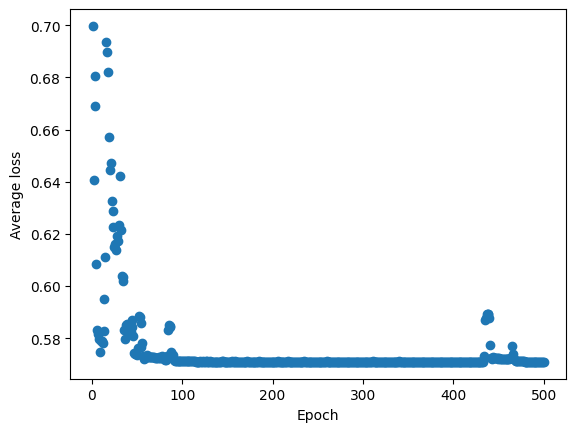

In [10]:

# Train the model
trained_model = train_model(input_data, desired_output, 500, viz_accuracy=True)


In [11]:
def test_model(trained_model, new_data, expected_result):
    test_input = torch.tensor(new_data, dtype=torch.float32)

    test_output = trained_model(test_input)
    print(test_output)

    predicted_classes = torch.argmax(test_output, dim=1)
    print(predicted_classes)

    test_output_compare = torch.tensor(expected_result, dtype=torch.int)
    print(test_output_compare)

    return float(sum(test_output_compare == predicted_classes)/len(test_input))

In [12]:
test_df = pd.read_csv("matrices_test.csv")
just_input_test = test_df.drop('last', axis=1)
input_data_test = np.array(just_input_test.values.tolist())
desired_output = torch.tensor(test_df['last'].tolist(), dtype=torch.float32).long()

test_model(trained_model, input_data_test, desired_output)

tensor([[1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        ...,
        [0.0000e+00, 1.0000e+00],
        [9.9990e-01, 9.6542e-05],
        [0.0000e+00, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
tensor([0, 0, 0,  ..., 1, 0, 1])
tensor([0, 0, 0,  ..., 0, 1, 1], dtype=torch.int32)


/var/folders/xs/6yx8fshd7_v5fg9sl09cfpdh0000gn/T/ipykernel_1096/2208809294.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_output_compare = torch.tensor(expected_result, dtype=torch.int)


0.7372000217437744

In [ ]:
# Generators for SL(3, Z)
x = np.array([[1, 0, 1],
                   [0, -1, -1],
                   [0, 1, 0]])

y = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [-1, -1, -1]])

z = np.array([[0, 1, 0],
                     [0, 0, 1],
                     [1, 0, 0]])

mat = np.array([[1, 0, 0],
                     [0, 1, 0],
                     [0, 0, 1]]) 
for i in range(500): 
    coin = random.randint(0,2)
    if coin == 0: 
        mat = np.matmul(x, mat)
    elif coin == 1: 
        mat = np.matmul(y, mat)
    else: 
        mat = np.matmul(z,mat)
mat

# prediction 



array([[  93,    9,   61],
       [ 922,   55,  590],
       [-752,  -49, -483]])

In [13]:
# testing out by starting with generated with our matrices 
a = np.array([[1, 1, 2],[0, 1, 1],[0,-3,-2]])
b = np.array([[-2, 0, -1],[-5, 1, -1],[3,0,1]])
mat = ([[1,0,0],[0,1,0],[0,0,1]])

aInv = np.array([[1, -4, -1],[0,-2,-1],[0,3,1]])
bInv = np.array([[1, 0, 1],[2, 1, 3],[-3,0,2]])

for i in range(1000):
    coin = random.randint(0,1)
    if coin == 0: 
        mat = np.matmul(a, mat)
    elif coin == 1: 
        mat = np.matmul(b, mat)


for i in range(300):
    input_array = np.array([mat[0][0],mat[0][1], mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1], mat[2][2]] )
    input_tensor = torch.tensor([input_array], dtype=torch.float32)
    prediction = trained_model(input_tensor)
    first_coordinate = prediction[0][0].item()
    print(first_coordinate)
    if abs(1 - first_coordinate) < abs(first_coordinate): 
        #apply a inv . 
        mat = np.matmul(aInv, mat)
    else: 
        mat = np.matmul(bInv, mat)
    if i == 0: 
            df = pd.DataFrame([[mat[0][0],mat[0][1],mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1],mat[2][2], round(prediction[0][0].item())]], columns = ['00', '01', '02','10','11','12', '20', '21','22',"last"])
    else: 
            df = pd.concat([df, pd.DataFrame([[mat[0][0],mat[0][1],mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1],mat[2][2], round(prediction[0][0].item())]],columns = ['00', '01', '02','10','11','12', '20', '21','22',"last"])])
    df.to_csv("Steps", index = False)

/var/folders/xs/6yx8fshd7_v5fg9sl09cfpdh0000gn/T/ipykernel_1096/2399871914.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  input_tensor = torch.tensor([input_array], dtype=torch.float32)


0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


(300, 9)


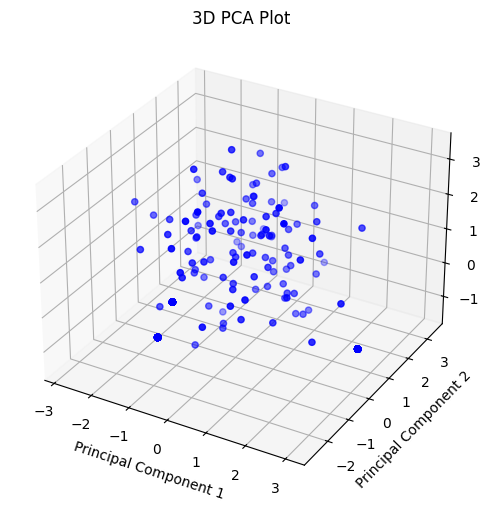

In [17]:
# trying pca 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
matrix = ['00','01','02','10','11','12','20','21','22']
x = df.loc[:, matrix].values
y = df.loc[:,['last']].values
x = StandardScaler().fit_transform(x)
print(x.shape)

#CHAT GPT

# Assuming 'x' is your original data
# PCA transformation
pca = PCA(n_components=3)
fittedData = pca.fit_transform(x)

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(fittedData[:, 0], fittedData[:, 1], fittedData[:, 2], c='b', marker='o')

# Set labels for each axis
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Set the plot title
ax.set_title('3D PCA Plot')

# Show the plot
plt.show()
